# Vision Transformer Image Explainability Research
By: Brett Huffman, [www.bretthuffman.com](https://www.bretthuffman.com)

Makes sure you are running GPU versions of Colab for these tests

With code from Aritra Roy Gosthipaty, Sayak Paul (https://github.com/sayakpaul/probing-vits)

In [1]:
!pip install -U gdown -q


In [2]:
import zipfile
from io import BytesIO

import cv2
import gdown
import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

In [3]:
RESOLUTION = 224
PATCH_SIZE = 16

In [4]:
crop_layer = keras.layers.CenterCrop(RESOLUTION, RESOLUTION)
norm_layer = keras.layers.Normalization(
    mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
    variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2],
)
rescale_layer = keras.layers.Rescaling(scale=1.0 / 127.5, offset=-1)


def preprocess_image(image, model_type, size=RESOLUTION):
    # Turn the image into a numpy array and add batch dim.
    image = np.array(image)
    image = tf.expand_dims(image, 0)

    # If model type is vit rescale the image to [-1, 1].
    if model_type == "original_vit":
        image = rescale_layer(image)

    # Resize the image using bicubic interpolation.
    resize_size = int((256 / 224) * size)
    image = tf.image.resize(image, (resize_size, resize_size), method="bicubic")

    # Crop the image.
    image = crop_layer(image)

    # If model type is DeiT or DINO normalize the image.
    if model_type != "original_vit":
        image = norm_layer(image)

    return image.numpy()


def load_image_from_url(url, model_type):
    # Credit: Willi Gierke
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    preprocessed_image = preprocess_image(image, model_type)
    return image, preprocessed_image


21675/21675 [==============================] - 0s 0us/step


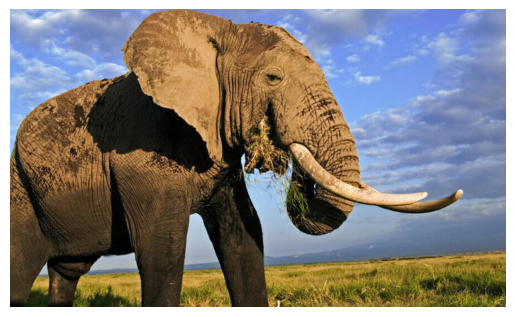

In [5]:
# ImageNet-1k label mapping file and load it.

mapping_file = keras.utils.get_file(
    origin="https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt"
)

with open(mapping_file, "r") as f:
    lines = f.readlines()
imagenet_int_to_str = [line.rstrip() for line in lines]

img_url = "https://files.worldwildlife.org/wwfcmsprod/images/African_Elephant_Kenya_112367/story_full_width/qxyqxqjtu_WW187785.jpg"
image, preprocessed_image = load_image_from_url(img_url, model_type="original_vit")

plt.imshow(image)
plt.axis("off")
plt.show()

## Load a model

In [6]:
import os
GITHUB_RELEASE = "https://github.com/sayakpaul/probing-vits/releases/download/v1.0.0/probing_vits.zip"
FNAME = "probing_vits.zip"
MODELS_ZIP = {
    "vit_b16_patch16_224": "Probing_ViTs/vit_b16_patch16_224.zip",
    "vit_b16_patch16_224-i1k_pretrained": "Probing_ViTs/vit_b16_patch16_224-i1k_pretrained.zip",
}

In [7]:
zip_path = tf.keras.utils.get_file(
    fname=FNAME,
    origin=GITHUB_RELEASE,
)

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./")

os.rename("Probing ViTs", "Probing_ViTs")


def load_model(model_path: str) -> tf.keras.Model:
    with zipfile.ZipFile(model_path, "r") as zip_ref:
        zip_ref.extractall("Probing_ViTs/")
    model_name = model_path.split(".")[0]

    inputs = keras.Input((RESOLUTION, RESOLUTION, 3))
    model = keras.models.load_model(model_name, compile=False)
    outputs, attention_weights = model(inputs, training=False)

    return keras.Model(inputs, outputs=[outputs, attention_weights])


vit_base_i21k_patch16_224 = load_model(MODELS_ZIP["vit_b16_patch16_224-i1k_pretrained"])
print("Model loaded.")

1346273766/1346273766 [==============================] - 7s 0us/step
Model loaded.


**More about the model**:

This model was pretrained on the ImageNet-21k dataset and was then fine-tuned on the
ImageNet-1k dataset. To learn more about how we developed this model in TensorFlow
(with pretrained weights from
[this source](https://github.com/google-research/vision_transformer/)).

* [Original ViT model (pretrained on ImageNet-21k)](https://drive.google.com/file/d/1mbtnliT3jRb3yJUHhbItWw8unfYZw8KJ/view?usp=sharing)
* [Original ViT model (pretrained on ImageNet-1k)](https://drive.google.com/file/d/1ApOdYe4NXxhPhJABefgZ3KVvqsQzhCL7/view?usp=sharing)

## Running regular inference with the model


In [8]:
predictions, attention_score_dict = vit_base_i21k_patch16_224.predict(
    preprocessed_image
)
predicted_label = imagenet_int_to_str[int(np.argmax(predictions))]
print(predicted_label)

1/1 [==============================] - 5s 5s/step
African_elephant, Loxodonta_africana


`attention_score_dict` contains the attention scores (softmaxed outputs) from each
attention head of each Transformer block.

## Attention Rollout

[Abnar et al.](https://arxiv.org/abs/2005.00928) introduce "Attention rollout" for
quantifying how information flow through self-attention layers of Transformer blocks.
Original ViT authors use this method to investigate the learned representations, stating:

> Briefly, we averaged attention weights of ViTL/16 across all heads and then recursively
multiplied the weight matrices of all layers. This accounts for the mixing of attention
across tokens through all layers.

We used
[this notebook](https://colab.research.google.com/github/jeonsworld/ViT-pytorch/blob/main/visualize_attention_map.ipynb)
and modified the attention rollout code from it for compatibility with our models.

In [9]:

def attention_rollout_map(image, attention_score_dict, model_type):
    num_cls_tokens = 2 if "distilled" in model_type else 1

    # Stack the individual attention matrices from individual Transformer blocks.
    attn_mat = tf.stack([attention_score_dict[k] for k in attention_score_dict.keys()])
    attn_mat = tf.squeeze(attn_mat, axis=1)

    # Average the attention weights across all heads.
    attn_mat = tf.reduce_mean(attn_mat, axis=1)

    # To account for residual connections, we add an identity matrix to the
    # attention matrix and re-normalize the weights.
    residual_attn = tf.eye(attn_mat.shape[1])
    aug_attn_mat = attn_mat + residual_attn
    aug_attn_mat = aug_attn_mat / tf.reduce_sum(aug_attn_mat, axis=-1)[..., None]
    aug_attn_mat = aug_attn_mat.numpy()

    # Recursively multiply the weight matrices.
    joint_attentions = np.zeros(aug_attn_mat.shape)
    joint_attentions[0] = aug_attn_mat[0]

    for n in range(1, aug_attn_mat.shape[0]):
        joint_attentions[n] = np.matmul(aug_attn_mat[n], joint_attentions[n - 1])

    # Attention from the output token to the input space.
    v = joint_attentions[-1]
    grid_size = int(np.sqrt(aug_attn_mat.shape[-1]))
    mask = v[0, num_cls_tokens:].reshape(grid_size, grid_size)
    mask = cv2.resize(mask / mask.max(), image.size)[..., np.newaxis]
    result = (mask * image).astype("uint8")
    return result


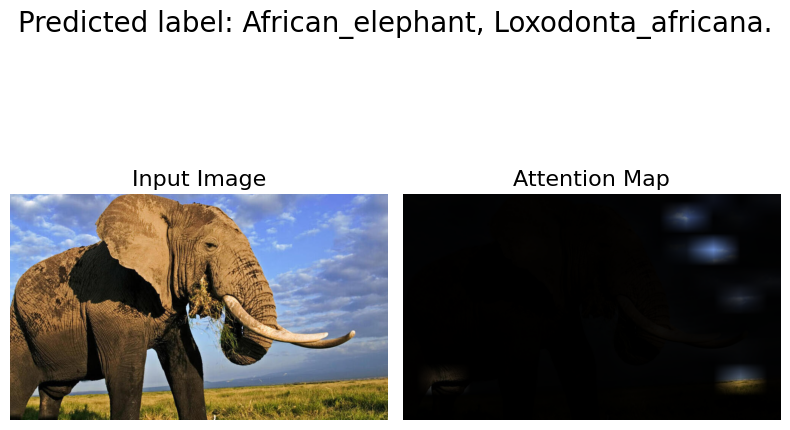

In [10]:
attn_rollout_result = attention_rollout_map(
    image, attention_score_dict, model_type="original_vit"
)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 10))
fig.suptitle(f"Predicted label: {predicted_label}.", fontsize=20)

_ = ax1.imshow(image)
_ = ax2.imshow(attn_rollout_result)
ax1.set_title("Input Image", fontsize=16)
ax2.set_title("Attention Map", fontsize=16)
ax1.axis("off")
ax2.axis("off")

fig.tight_layout()
fig.subplots_adjust(top=1.35)
fig.show()

## Acknowledgements

- [PyImageSearch](https://pyimagesearch.com)
- [Jarvislabs.ai](https://jarvislabs.ai/)
- [GDE Program](https://developers.google.com/programs/experts/)
- [Probing ViTs](https://github.com/sayakpaul/probing-vits)